Remarks 250523
- Added initial cell to reload modules automatically 
- In `FormatData` definition
  - file paths are hardcoded -> either provide it as a fct parameter or mention in readme how names should be formatted
  - the line `self.adata.obs = metadata_df` rewrites `self.adata.obs_names` as well!! --> I don't know if this should later be fixed?
- In readme
  - in `FormatData` documentation, `.x_train` and `.x_test` are said to be DataFrames but I think they're arrays
  - `.selected_genes` are explained twice (and are the same info as `.genes`)
  - in `binary_pso` documentation, `current_data` is said to be a dataframe, but I think it is a `FormatData` object
- ??? Why are HVGs selected from training data ???
- In PSO algorithm the number of generations should be 5 but it runs for 6 nonono è che il codice ha settato le generazioni a 15 shit
- Why are there 2000 current genes but genes_list has 18116 elements?

In [1]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

In [2]:
# import pickle
# import pandas as pd
# from PAGEpy import PAGEpy_utils

from PAGEpy import PAGEpy_plot
from PAGEpy import pso_PRISCA as pso
from PAGEpy.format_data_class import FormatData
from PAGEpy.models import PredAnnModel
import pickle
import pandas as pd
from PAGEpy import PAGEpy_utils

In [3]:
# memory growth is enabled for for the gpu
PAGEpy_utils.init_cuda()

In [4]:
# HVGs are selected by default, as opposed to the differential expression
current_data = FormatData(
    data_dir="../../HIVdata/",
    gene_selection="HVG",
    pval_correction="benjamini-hochberg",
    hvg_count=2000,
)

Anndata successfully constructed.
Anndata object counts are now normalized.
The total length of the genes list or feature set is: 2000.


In [5]:
# the selected genes can be loaded from the local directory, however, they are also an attribte of the FormatData object
genes_path = "feature_set.pkl"
# TO DO: modify FormatData so that it is possible to manage this file

with open(genes_path, "rb") as f:
    current_genes = pickle.load(f)

In [6]:
# train the model; TO DO: modify PredAnnModel to only create the model and not train it
old_model = PredAnnModel(
    current_data, current_genes,
    # num_epochs=500,
    n_epochs=50,
    auc_threshold=1
)

Epoch 0, Avg Outcome Loss: 0.6957, Train AUC: 0.5000, Train Accuracy: 0.4518, Test AUC: 0.5000, Test Accuracy: 0.4520
Epoch 10, Avg Outcome Loss: 0.5423, Train AUC: 0.8701, Train Accuracy: 0.7512, Test AUC: 0.8500, Test Accuracy: 0.7426
Epoch 20, Avg Outcome Loss: 0.4839, Train AUC: 0.8805, Train Accuracy: 0.8030, Test AUC: 0.8577, Test Accuracy: 0.7968
Epoch 30, Avg Outcome Loss: 0.4479, Train AUC: 0.8871, Train Accuracy: 0.8068, Test AUC: 0.8605, Test Accuracy: 0.7977
Epoch 40, Avg Outcome Loss: 0.3917, Train AUC: 0.9076, Train Accuracy: 0.8246, Test AUC: 0.8792, Test Accuracy: 0.7987


max train accuracy: 0.84
max train auc: 0.91
max test accuracy: 0.82
max test auc: 0.89


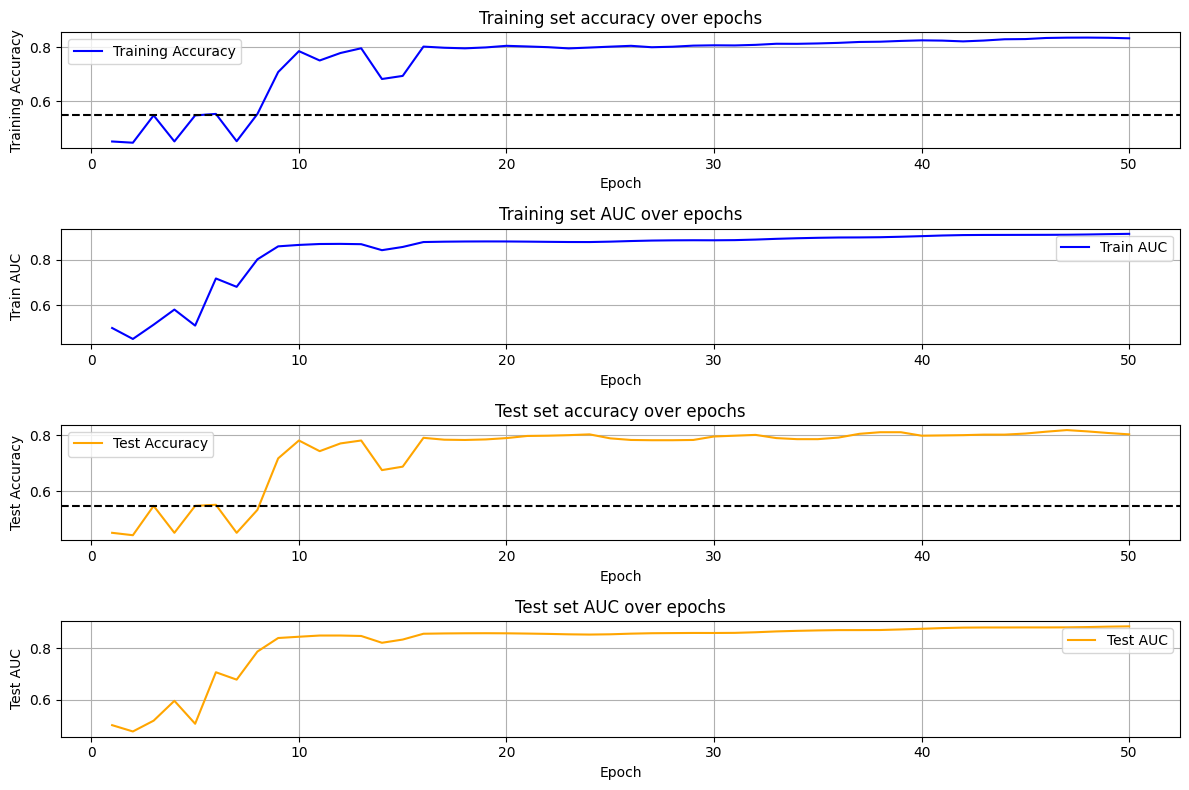

In [7]:
# evaluate the model
PAGEpy_plot.evaluate_model(old_model, current_data)

In [8]:
# the pso algorithm can be use to optimze the solution
best_solution, best_fitness = pso.run_binary_pso(
    input_data=current_data,
    feature_names=current_genes,
    # pop_size=200,
    pop_size=5,
    # n_generations=15,
    n_generations=2,
    w=1,
    c1=2,
    c2=1.5,
    # n_reps=4,
    n_reps=1,
    # frequent_reporting=False,
    verbose=True,
    adaptive_metrics=False
)

Using mixed precision policy: mixed_float16
Training particle 1, generation 1 with 951 genes
  Fold 1/5: AUC = 0.9011
  Fold 2/5: AUC = 0.8721
  Fold 3/5: AUC = 0.8898
  Fold 4/5: AUC = 0.8914
  Fold 5/5: AUC = 0.8884
All folds completed for particle 1, generation 1
Average final test AUC value: 0.8889999985694885
Total time: 11.631180763244629 seconds
Training particle 2, generation 1 with 1032 genes
  Fold 1/5: AUC = 0.8899
  Fold 2/5: AUC = 0.8915
  Fold 3/5: AUC = 0.8912
  Fold 4/5: AUC = 0.9097
  Fold 5/5: AUC = 0.9046
All folds completed for particle 2, generation 1
Average final test AUC value: 0.8970000147819519
Total time: 12.323190689086914 seconds
Training particle 3, generation 1 with 981 genes
  Fold 1/5: AUC = 0.8999
  Fold 2/5: AUC = 0.8796
  Fold 3/5: AUC = 0.8816
  Fold 4/5: AUC = 0.8950
  Fold 5/5: AUC = 0.8806
All folds completed for particle 3, generation 1
Average final test AUC value: 0.8870000243186951
Total time: 12.208214044570923 seconds
Training particle 4, g

In [10]:
# the results of pso optimizatoin can be monitored
pso_df = pd.read_pickle("pso_fitness_scores.pkl")
pso_dict = pd.read_pickle("pso_particle_history.pkl")

PAGEpy_plot.plot_pso_row_averages(pso_df)
PAGEpy_plot.plot_hamming_distance(pso_dict)
PAGEpy_plot.plot_sorted_frequencies(pso_dict, pso_df)

AttributeError: 'list' object has no attribute 'mean'

In [ ]:
# the optimised solution is saved locally, however, the returned varible from the binary_pso function can also be passed to the model (see below)
# pso_genes = [item for item, m in zip(current_genes, best_solution) if m == 1]

# othervise just load the locally stored result file

# Load the saved genes list
with open("pso_selected_genes.pkl", "rb") as f:
    pso_genes = pickle.load(f)

Epoch 0, Avg Outcome Loss: 0.6960, Train AUC: 0.6719, Train Accuracy: 0.5482, Test AUC: 0.6802, Test Accuracy: 0.5480
Epoch 10, Avg Outcome Loss: 0.4935, Train AUC: 0.8573, Train Accuracy: 0.7217, Test AUC: 0.8461, Test Accuracy: 0.7075
Epoch 20, Avg Outcome Loss: 0.4945, Train AUC: 0.8723, Train Accuracy: 0.7612, Test AUC: 0.8574, Test Accuracy: 0.7407
Epoch 30, Avg Outcome Loss: 0.4295, Train AUC: 0.8986, Train Accuracy: 0.8056, Test AUC: 0.8832, Test Accuracy: 0.8053
Epoch 40, Avg Outcome Loss: 0.4043, Train AUC: 0.8996, Train Accuracy: 0.8268, Test AUC: 0.8831, Test Accuracy: 0.8034
Epoch 50, Avg Outcome Loss: 0.3859, Train AUC: 0.9075, Train Accuracy: 0.8346, Test AUC: 0.8905, Test Accuracy: 0.8177
Epoch 60, Avg Outcome Loss: 0.3899, Train AUC: 0.9092, Train Accuracy: 0.8353, Test AUC: 0.8922, Test Accuracy: 0.8177
Epoch 70, Avg Outcome Loss: 0.3808, Train AUC: 0.9105, Train Accuracy: 0.8372, Test AUC: 0.8933, Test Accuracy: 0.8196
Epoch 80, Avg Outcome Loss: 0.3676, Train AUC: 0.

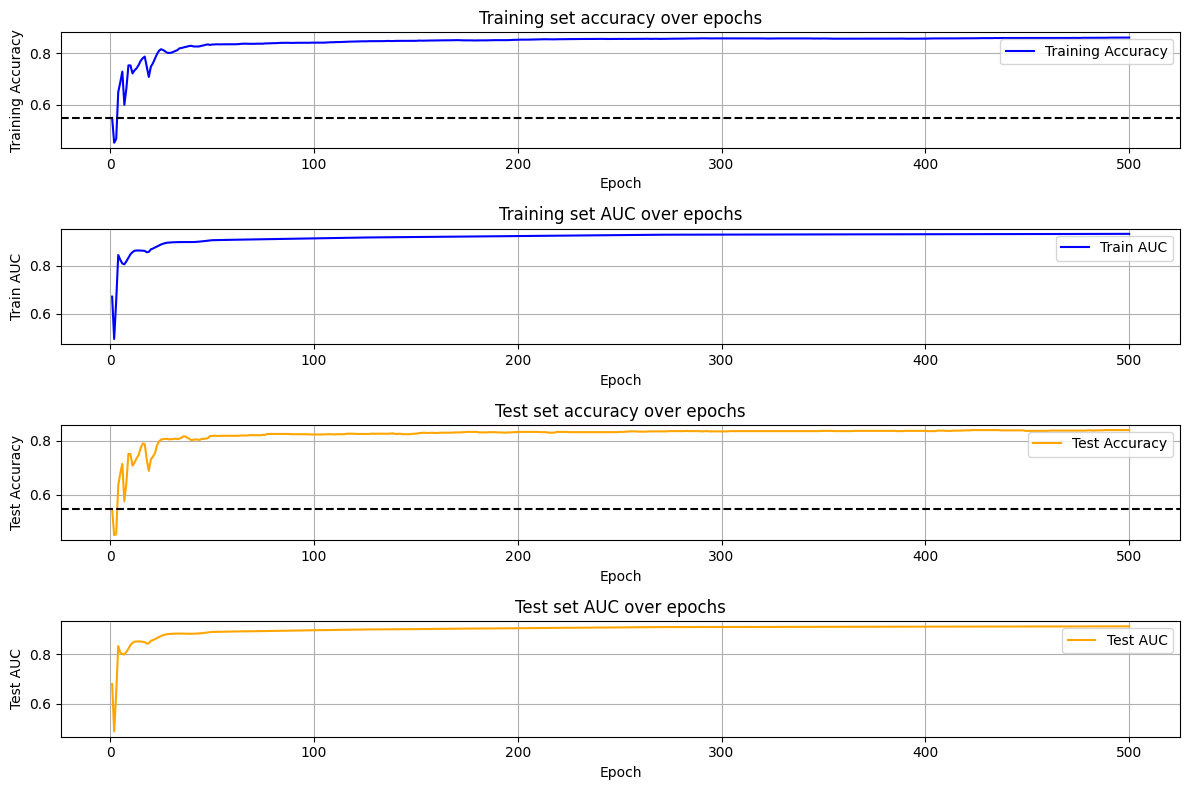

In [ ]:
# now use this gene list to train a new model, which you can then evaluate
new_model = PredAnnModel(current_data, pso_genes, n_epochs=500)
PAGEpy_plot.evaluate_model(new_model, current_data)